# Mailinator message analysis pipeline for identifying scammy Bitcoin addresses

There are, supposedly, a number of scam emails sent to Mailinator public inboxes that solicit funds to be sent to Bitcoin addresses. We want to identify the messages with these addresses (and, of course, the addresses themselves). 

General procedure:
+ Use API to acquire raw message text (use `Thread` to increase efficiency) 
+ NLP techniques to simplify message text for analysis (tokenization, etc.)
+ Identify Bitcoin address pattern and/or language surrounding scam attempts — flag individual messages that contain relevant characteristics
+ Individually investigate flagged messages

At the bottom of this notebook, there are some earlier, alternate strategies that were ultimately unsuccessful or slower than what is described above.

Cedric, November 19, 2020

**Some background on Mailinator**

With a paid subscription, all Mailinator public inboxes, and messages contained in those inboxes, are accessible one at a time via an API. Messages remain several hours in a Mailinator public inbox before they are deleted forever. 

From https://www.mailinator.com/index.jsp:

*Public Mailinator is free, disposable, email. Every possible email address @mailinator.com is available for you (and everyone else) to use.*

*No Signup. No Login. You don't even "create" email addresses - They ALL already exist! That's right, every possible email address @mailinator.com already exists.*

*Typically, you use the Public Mailinator system when you need to give out an email address, but don't want to give your primary email address because you might get spammed. In those cases, make up a Mailinator email address on the fly (how about joe123@mailinator.com? Or, happybill@mailinator.com - use anything you want!). You can then come to the Mailinator website and check that inbox and read any email!*

In [98]:
import requests, json, datetime, timeit, time, pandas as pd
from threading import Thread
from itertools import chain

**Using API**

Use one API call to get all message id from an inbox and a second to acquire the text of the message corresponding to that particular id.

Mailinator API documentation: https://manybrain.github.io/m8rdocs/#mailinator

Tutorial for using `Thread`: https://nbviewer.jupyter.org/gist/minrk/5732094

Sometimes get this error depending on what inboxes looping through (not sure why): https://stackoverflow.com/questions/16573332/jsondecodeerror-expecting-value-line-1-column-1-char-0

In [84]:
# THE API KEY IS NOW EXPIRED! (It was "live" only for a two-week free trial, which has now passed.)
api_key_mailinator = 'c70a3c833e3e44fca7d573f287e9a3e2'

api_inbox_summary_base = 'https://www.mailinator.com/api/v2/domains/public/inboxes/{0}'

api_message_base = 'https://mailinator.com/api/v2/domains/public/inboxes/{0}/messages/{1}'

def api_to_json(api_url, inbox, message_id=None):
    """process a single api call"""
    # fetch the data
    r = requests.get(api_url.format(inbox,message_id),headers={'Authorization':api_key_mailinator})        
    # parse the json reply
    data_json = r.json()
    return data_json

def inbox_to_message_df(inbox):
    inbox_df_list = []
    message_summaries_json = api_to_json(api_inbox_summary_base,inbox)['msgs']
    message_summary_bits_list = [(message_summary['fromfull'],message_summary['time'],message_summary['id'],message_summary['subject']) for message_summary in message_summaries_json]
    for bit in message_summary_bits_list:
        message_json = api_to_json(api_message_base,inbox,bit[2])
        try:
            df_message = pd.DataFrame({'sent_from_email': [bit[0]],
                                     'sent_to_inbox': [inbox],
                                     'sent_time': [bit[1]],
                                     'message_id': [bit[2]],
                                     'message_subject': [bit[3]],
                                     'message_body_1': [message_json['parts'][0]['body']],
                                     'message_body_2': [message_json['parts'][1]['body']]
                                    })
            inbox_df_list.append(df_message)
        except:
            json_list_df_fails.append(message_json)
    return inbox_df_list

In [39]:
def process_range(inbox_list,store=None):
    """process a number of api calls, storing the results in a dict"""
    if store is None:
        store = {}
    for inbox in inbox_list:
        store[inbox] = inbox_to_message_df(inbox)
    return store

In [40]:
def threaded_process(nthreads, inbox_list):
    """process the inbox_list in a specified number of threads"""
    store = {}
    threads = []
    # create the threads
    for i in range(nthreads):
        ids = inbox_list[i::nthreads]
        t = Thread(target=process_range, args=(ids,store))
        threads.append(t)
    
    # start the threads
    [ t.start() for t in threads ]
    # wait for the threads to finish
    [ t.join() for t in threads ]
    return store

In [28]:
# figure out what the optimal thread number is (this and two subsequent blocks of code)

id_range = inbox_names
tic = time.time()
reference = process_range(id_range)
reftime = time.time() - tic
print(1, reftime)

nlist = [1,2,4,8,16,32,64,128]
tlist = [reftime]
for nthreads in nlist[1:]:
    tic = time.time()
    ans = threaded_process(nthreads, id_range)
    toc = time.time()
    print(nthreads, toc-tic)
    assert ans == reference
    tlist.append(toc-tic)

1 0.9264349937438965
2 0.5362968444824219
4 0.35472679138183594
8 0.19941401481628418
16 0.19248676300048828
32 0.185927152633667
64 0.18691205978393555
128 0.18964815139770508


In [25]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


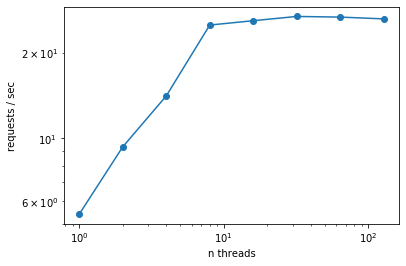

In [34]:
plt.loglog(nlist, [ len(id_range) / t for t in tlist], '-o')
plt.xlabel("n threads")
plt.ylabel("requests / sec");

In [71]:
# inbox names list

baby_names = pd.read_csv('baby-names.csv')
inbox_names = list(baby_names.name)[:20] # get 20 inboxes for now
inbox_names = [name.lower() for name in inbox_names]

In [103]:
# this is the actual compilation of data from the api call — just plug in the inbox names to pull and go!

# time at which to mark files if exported from this pull
#time = datetime.datetime.now()

# as we can see from the graph above, it doesn't make sense to have more than 8 threads (at least for my computer!)
n = 8

dictionary_inboxes_to_message_dfs = threaded_process(n,['person','man','woman','apples']) # replace with inbox_names

df_list = [item for item in dictionary_inboxes_to_message_dfs.values() if item != []]

df_list = list(chain.from_iterable(df_list))

df_full = pd.concat(df_list,ignore_index=True)

df_full['match_flag'] = 0

df_full.head(10)

,sent_from_email,sent_to_inbox,sent_time,message_id,message_subject,message_body_1,message_body_2,match_flag
0,noreply@twoomail.com,man,1605838522000,man-1605838522-190168,"🎁 Man, look what we've found in Shivaji Nagar!",? \r\n\r\nHere's the treat that got lost\r\n\r...,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 3.2 Fi...",0


In [1]:
# export/save the output

#df_full.to_csv('.../pull at ' + str(time) + '.csv')
#json_list_df_fails.to_csv(r'.../json failed df convert pull at ' + str(time) + '.txt')

**Natural Language Processing**

Identify address patterns to flag messages that yield a match (potentially a fuzzy match or match on a prefix/length/character type count/etc.). Likely more efficient to pull everything first and then do analysis second (rather than searching text upfront during pull).

Resources:
+ http://www.nltk.org/book/

In [3]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re

In [4]:
# function that tokenizes message bodies and puts the text into a list that occupies a single cell in a new df column
# change tokenization to whatever is most expedient as project evolves

def apwords(words):
    filtered_sentence = []
    words = word_tokenize(words)
    for w in words:
        if w not in stopwords.words('english'):
            filtered_sentence.append(w)
    return filtered_sentence
addwords = lambda x: apwords(x)

df_full['tokenized_words_1'] = df_full['message_body_1'].apply(addwords)
df_full['tokenized_words_2'] = df_full['message_body_2'].apply(addwords)
        
df_full.head(10)

,sent_from_email,sent_to_inbox,sent_time,message_id,message_subject,message_body_1,message_body_2,match_flag,tokenized_words_1,tokenized_words_2
0,Trump2020GolfBalls@visionsupport.buzz,person,1.605722e+12,person-1605721579-22704,Make American Great Again!,\r\n\r\n\r\nCLAIM Your Trump 2020 Commemorat...,<html>\r\n<head>\r\n\t<title>Newsletter</title...,0,"[CLAIM, Your, Trump, 2020, Commemorative, Golf...","[<, html, >, <, head, >, <, title, >, Newslett..."
1,practicalpsychologytips@gmail.com,person,1.605736e+12,person-1605735604-830216,It's ready: 30 Day Brain Bootcamp!,Hey!\r\n\r\nI'm super excited to share with yo...,"\r\n\r\n<meta http-equiv=""Content-Type"" conten...",0,"[Hey, !, I, 'm, super, excited, share, favorit...","[<, meta, http-equiv=, '', Content-Type, '', c..."
2,info@daydesigner.com,man,1.605730e+12,man-1605729866-560491,Which Planner Is Right For You?,(\r\nhttps://click.convertkit-mail.com/mvuxz8p...,\r\n\r\r\n<!--[if mso]>\r\r\n <center>\r\r\n <...,0,"[(, https, :, //click.convertkit-mail.com/mvux...","[<, !, --, [, mso, ], >, <, center, >, <, tabl..."
3,daily@adifmail.co.il,man,1.605732e+12,man-1605732234-624182,עדיף יומי 18/11/2020,‏\r\n אם אינך רואה מייל זה אנא לחץ כאן\r\n ניו...,<!DOCTYPE html><!DOCTYPE html PUBLIC '-//W3C//...,0,"[‏, אם, אינך, רואה, מייל, זה, אנא, לחץ, כאן, נ...","[<, !, DOCTYPE, html, >, <, !, DOCTYPE, html, ..."
4,photoserge@z.kajabimail.net,camera,1.605733e+12,camera-1605733128-656946,Are you using these 6 special techniques with ...,‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ...,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.01 T...",0,"[‌, ‌, ‌, ‌, ‌, ‌, ‌, ‌, ‌, ‌, ‌, ‌, ‌, ‌, ‌, ...","[<, !, DOCTYPE, HTML, PUBLIC, ``, -//W3C//DTD,..."
5,casino@BetBigDollar.com,tv,1.605728e+12,tv-1605728441-389045,"Tommy, visualise your wins!","Tommy, visualise your wins!\n320% Match + 75 ...",<!doctype html>\n<html>\n <head>\n <meta...,0,"[Tommy, ,, visualise, wins, !, 320, %, Match, ...","[<, !, doctype, html, >, <, html, >, <, head, ..."
6,casino@BetBigDollar.com,tv,1.605735e+12,tv-1605735400-756951,Your third secret vault code...,Your third secret vault code...\nPlus an extra...,<!doctype html>\n<html>\n <head>\n <meta...,0,"[Your, third, secret, vault, code, ..., Plus, ...","[<, !, doctype, html, >, <, html, >, <, head, ..."


In [7]:
# re.match(REGEXP,TEXT) to flag messages that are a match to the REGEXP
# change REGEXP once Bitcoin address regexp format identified

for i, row in df_full.iterrows():
    if any(re.match('trump',word.lower()) for word in (df_full.loc[i,'tokenized_words_1'] or df_full.loc[i,'tokenized_words_2'])):
        df_full.loc[i,'match_flag'] = 1
    else:
        df_full.loc[i,'match_flag'] = 0
        
df_full.head(10)

,sent_from_email,sent_to_inbox,sent_time,message_id,message_subject,message_body_1,message_body_2,match_flag,tokenized_words_1,tokenized_words_2
0,Trump2020GolfBalls@visionsupport.buzz,person,1.605722e+12,person-1605721579-22704,Make American Great Again!,\r\n\r\n\r\nCLAIM Your Trump 2020 Commemorat...,<html>\r\n<head>\r\n\t<title>Newsletter</title...,1,"[CLAIM, Your, Trump, 2020, Commemorative, Golf...","[<, html, >, <, head, >, <, title, >, Newslett..."
1,practicalpsychologytips@gmail.com,person,1.605736e+12,person-1605735604-830216,It's ready: 30 Day Brain Bootcamp!,Hey!\r\n\r\nI'm super excited to share with yo...,"\r\n\r\n<meta http-equiv=""Content-Type"" conten...",0,"[Hey, !, I, 'm, super, excited, share, favorit...","[<, meta, http-equiv=, '', Content-Type, '', c..."
2,info@daydesigner.com,man,1.605730e+12,man-1605729866-560491,Which Planner Is Right For You?,(\r\nhttps://click.convertkit-mail.com/mvuxz8p...,\r\n\r\r\n<!--[if mso]>\r\r\n <center>\r\r\n <...,0,"[(, https, :, //click.convertkit-mail.com/mvux...","[<, !, --, [, mso, ], >, <, center, >, <, tabl..."
3,daily@adifmail.co.il,man,1.605732e+12,man-1605732234-624182,עדיף יומי 18/11/2020,‏\r\n אם אינך רואה מייל זה אנא לחץ כאן\r\n ניו...,<!DOCTYPE html><!DOCTYPE html PUBLIC '-//W3C//...,0,"[‏, אם, אינך, רואה, מייל, זה, אנא, לחץ, כאן, נ...","[<, !, DOCTYPE, html, >, <, !, DOCTYPE, html, ..."
4,photoserge@z.kajabimail.net,camera,1.605733e+12,camera-1605733128-656946,Are you using these 6 special techniques with ...,‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ‌ ...,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 4.01 T...",0,"[‌, ‌, ‌, ‌, ‌, ‌, ‌, ‌, ‌, ‌, ‌, ‌, ‌, ‌, ‌, ...","[<, !, DOCTYPE, HTML, PUBLIC, ``, -//W3C//DTD,..."
5,casino@BetBigDollar.com,tv,1.605728e+12,tv-1605728441-389045,"Tommy, visualise your wins!","Tommy, visualise your wins!\n320% Match + 75 ...",<!doctype html>\n<html>\n <head>\n <meta...,0,"[Tommy, ,, visualise, wins, !, 320, %, Match, ...","[<, !, doctype, html, >, <, html, >, <, head, ..."
6,casino@BetBigDollar.com,tv,1.605735e+12,tv-1605735400-756951,Your third secret vault code...,Your third secret vault code...\nPlus an extra...,<!doctype html>\n<html>\n <head>\n <meta...,0,"[Your, third, secret, vault, code, ..., Plus, ...","[<, !, doctype, html, >, <, html, >, <, head, ..."


### Previous methods

Below are methods of acquiring emails by using the API and just looping through (slower than `Thread` approach above) and regular web scraping/crawling (this just didn't work very well), respectively.

**Using API**

Use one API call to get all message id from an inbox and a second to acquire the text of the message corresponding to that particular id.

In [3]:
#%%timeit
# messages from a single address's inbox
api_inbox_summary_base = 'https://www.mailinator.com/api/v2/domains/public/inboxes/'
inbox = 'apples'

response = requests.get(api_inbox_summary_base + inbox,headers={'Authorization':'c70a3c833e3e44fca7d573f287e9a3e2'})

message_summary_df = pd.DataFrame(response.json()['msgs'])
api_message_base_1 = 'https://mailinator.com/api/v2/domains/'
api_message_base_2 = '/inboxes/'
api_message_base_3 = '/messages/'

df_full = pd.DataFrame({'sent_from_email':[], 'sent_to_inbox':[], 'sent_time':[], 'message_id':[], 
                       'message_subject':[], 'message_body_1':[], 'message_body_2':[]}) 
df_list = []
json_list = []
json_list_fails = []
message_list = []

for message_id in message_summary_df['id']:
    message = requests.get(api_message_base_1 + 'public' + api_message_base_2 + inbox + api_message_base_3 + message_id, 
                headers={'Authorization':'c70a3c833e3e44fca7d573f287e9a3e2'})
    json_list.append(message.json())

    try:
        df_message = pd.DataFrame({'sent_from_email': message_summary_df[message_summary_df['id'] == message_id]['fromfull'],
                                 'sent_to_inbox': inbox,
                                 'sent_time': message_summary_df[message_summary_df['id'] == message_id]['time'],
                                 'message_id': message_id,
                                 'message_subject': message_summary_df[message_summary_df['id'] == message_id]['subject'],
                                 'message_body_1': message.json()['parts'][0]['body'],
                                 'message_body_2': message.json()['parts'][1]['body']
                                })
        df_full = pd.concat([df_full, df_message],ignore_index=True)

    except:
        json_list_fails.append(message.json()) 

df_full['match_flag'] = 0
df_full.head(10)

,sent_from_email,sent_to_inbox,sent_time,message_id,message_subject,message_body_1,message_body_2,match_flag
0,events@eventful.com,apples,1.605824e+12,apples-1605823991-638545,"The Reel Buzz - New movies in theaters, stream...",attachment removed,attachment removed,0
1,greg@kinobody.com,apples,1.605837e+12,apples-1605837329-427012,How to Gain 10 pounds of Pure Muscle (Strength...,<https://superherobulking.com/launch/>\r\n\r\n...,"<!DOCTYPE html PUBLIC ""-//W3C//DTD XHTML 1.0 T...",0


In [4]:
#%%timeit
# messages from multiple addresses's inboxes

time = datetime.datetime.now()

api_inbox_summary_base = 'https://www.mailinator.com/api/v2/domains/public/inboxes/'

api_message_base_1 = 'https://mailinator.com/api/v2/domains/'
api_message_base_2 = '/inboxes/'
api_message_base_3 = '/messages/'

# export as csv
df_full = pd.DataFrame({'sent_from_email':[], 'sent_to_inbox':[], 'sent_time':[], 'message_id':[], 
                       'message_subject':[], 'message_body_1':[], 'message_body_2':[]}) 

# export as txt
json_list = []
json_list_df_fails = []
empty_inboxes = [] #maybe not necessary

# PUT NEW INBOX NAMES HERE!!!
inbox_names = ['person','woman','man','camera','tv']

for inbox in inbox_names:
    response = requests.get(api_inbox_summary_base + inbox,headers={'Authorization':'c70a3c833e3e44fca7d573f287e9a3e2'})
    try:
        message_summary_df = pd.DataFrame(response.json()['msgs'])
        for message_id in message_summary_df['id']:
            message = requests.get(api_message_base_1 + 'public' + api_message_base_2 + inbox + api_message_base_3 + message_id, 
                        headers={'Authorization':'c70a3c833e3e44fca7d573f287e9a3e2'})
            json_list.append(message.json())
        
            try:  
                df_message = pd.DataFrame({'sent_from_email': message_summary_df[message_summary_df['id'] == message_id]['fromfull'],
                                     'sent_to_inbox': inbox,
                                     'sent_time': message_summary_df[message_summary_df['id'] == message_id]['time'],
                                     'message_id': message_id,
                                     'message_subject': message_summary_df[message_summary_df['id'] == message_id]['subject'],
                                     'message_body_1': message.json()['parts'][0]['body'],
                                     'message_body_2': message.json()['parts'][1]['body']
                                    })
                df_full = pd.concat([df_full, df_message],ignore_index=True)
                                      
            except:
                json_list_df_fails.append(message.json())
    except:
        empty_inboxes.append(inbox)
    
df_full['match_flag'] = 0

df_full.head(10)

#df_full.to_csv('.../pull at ' + str(time) + '.csv')
#json_list.to_csv(r'.../full json pull at ' + str(time) + '.txt')
#json_list_df_fails.to_csv(r'.../json failed df convert pull at ' + str(time) + '.txt')

,sent_from_email,sent_to_inbox,sent_time,message_id,message_subject,message_body_1,message_body_2,match_flag
0,max@flybusinesscheap.com,person,1.605819e+12,person-1605818632-25976,SURPRISE! Business class with 70% OFF,\r\n. [http://r20.rs6.net/tn.jsp?f=001WoZz6_-d...,"\r\n\r\n<body topmargin=""0"" leftmargin=""0"" rig...",0
1,info@e.homehardware.ca,man,1.605827e+12,man-1605827096-753877,Get a jump on pre-Black Friday savings,\r\n\r\n\r\n\r\n\r\n\r\n\r\n\r\n \r\n/* * { -...,"<!DOCTYPE html>\r\n<html xmlns=""http://www.w3....",0
2,noreply@twoomail.com,man,1.605839e+12,man-1605838522-190168,"🎁 Man, look what we've found in Shivaji Nagar!",? \r\n\r\nHere's the treat that got lost\r\n\r...,"<!DOCTYPE HTML PUBLIC ""-//W3C//DTD HTML 3.2 Fi...",0


**Web Crawling (CAN'T GET IT TO WORK WELL — API IS MUCH MORE EFFICIENT)**

My guess is that the site is designed specifically to prevent this method of mail acquisition (i.e., they want people to use their *paid* API!).

Resources:
+ https://www.scrapingbee.com/blog/selenium-python/

In [ ]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

In [ ]:
# will open chrome window

driver = webdriver.Chrome()
driver.get('https://www.mailinator.com/')

# potentially add login

search_box = driver.find_element_by_xpath('//*[@id="addOverlay"]')
search_box.send_keys('apples') # inbox name

go_button = driver.find_element_by_xpath('/html/body/header/div[1]/div/div/div[2]/div/div/div')
go_button.click()

emails_in_inbox = driver.find_elements_by_xpath('//*[(@id = "inboxpane")]//a')

message_list = []
just_messages = []

for email in emails_in_inbox:
    try:
        email.click()
        
        # this is the super hard-to-find part — I think the point is they want us to use the (pay-to-play) API
        message_list.append({'message_info':driver.find_element_by_xpath('//*[@id="msgpane"]/div/div/div[1]').text,
         'message_body':driver.find_element_by_xpath(...).text})  
        
        back_to_inbox = driver.find_element_by_xpath('//*[@id="msgpane"]/div/div/div[2]/a')
        back_to_inbox.click()
    except:
        pass
    
just_messages

In [ ]:
# run chrome in headless mode (without graphical user interface)
# runs it on a server

from selenium.webdriver.chrome.options import Options

options = Options()
options.headless = True
options.add_argument("--window-size=1920,1200")

driver = webdriver.Chrome(options=options) # must specify options for headless
driver.get("https://www.mailinator.com/")
print(driver.title) # get page's title
print(driver.current_url) # get current url
print(driver.page_source) # returns html source code
driver.quit()